In [4]:
# nEpochs=20  # orig, longer training
nEpochs=3  # quick testing during development

# Select one (and only one) model to train
USE_CGAN = False
USE_CVAE = False
USE_CVAECGAN = True

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
if model_name not in {"cgan", "cvae", "cvaecgan"}:
    raise Exception("Double check you are only using one model. The current model name is invalid")

## 1. Import 3rd party libraries 

In [5]:
import os
import session_info
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
print(tf.test.is_gpu_available())

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    )
except:
    Warning("Unable To configure Tensorflow GPU")
    
# Import our own classes 
current_dir =  '/project/nanocourse/SWE_OOP/train09/Module_2_Materials/04_ExerciseCodeAndInstructions/HPO'
os.chdir(current_dir)
print("Current working directory:", os.getcwd())
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

#session_info.show()

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Current working directory: /project/nanocourse/SWE_OOP/train09/Module_2_Materials/04_ExerciseCodeAndInstructions/HPO


I0000 00:00:1748578891.699116   53368 gpu_device.cc:2019] Created device /device:GPU:0 with 15252 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


## 3. Show some our data

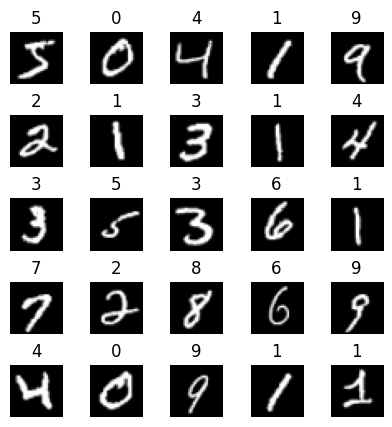

In [6]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist' + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [8]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'generator_params' : {
        'generator_conv_layer_units' : [128,128],
        'generator_conv_layer_kernel_size' : [4,4],
        'generator_conv_layer_strides' : [(2,2), (2,2)],
        'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
        'discriminator_dense_layer_units' : [128],
        'generator_dense_layer_units' : [],
    },
    'discriminator_params' : {
        'discriminator_conv_layer_units' : [32,64],
        'discriminator_conv_layer_kernel_size' : [4,4],
        'discriminator_conv_layer_strides' : [(1,1), (2,2)],
        'discriminator_conv_layer_activation_functions' : ['relu','relu'],
        'discriminator_dense_layer_units' : [],
        'generator_dense_layer_units' : [],
    }
}

if USE_CGAN:
    model = ConditionalGAN(n_classes=n_classes,
                                 n_latent_dims = hpo_params['n_latent_dims'],
                                 generator_params = hpo_params['generator_params'],
                                 discriminator_params = hpo_params['discriminator_params'])
if USE_CVAE:
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
    )
if USE_CVAECGAN:
    model = ConditionalVAECGAN(adv_loss_weight=10., 
                            n_classes=n_classes,
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params=hpo_params['encoder_params'],
                            decoder_params=hpo_params['decoder_params'],
                            discriminator_params=hpo_params['discriminator_params']
    )




In [9]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input(shape=(model.n_latent_dims+model.n_classes,))
    gen_out  = model.generator.call(gen_in) 
    gen = tf.keras.Model(gen_in, gen_out) 
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input(shape=(model.n_latent_dims+model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input(shape=(model.n_latent_dims + model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(model.image_shape) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()


=== OVERALL MODEL ====


ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [6]:
_ = model([data.images_train[:1], labels_onehot[:1]])

I0000 00:00:1748577364.807401   14616 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 

model.compile(optimizer_encoder=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']),
              optimizer_decoder=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']),
              optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)



## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 74s 143ms/step - class_loss: 0.4168 - dec_loss: 104.3756 - disc_loss: 0.4358 - enc_loss: 153.6917 - kl_loss: 50.0332 - recon_loss: 103.6585 - top_1_acc: 0.8924
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 143ms/step - class_loss: 0.0573 - dec_loss: 36.0946 - disc_loss: 0.0576 - enc_loss: 42.3546 - kl_loss: 6.2857 - recon_loss: 36.0689 - top_1_acc: 0.9813
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - class_loss: 0.0380 - dec_loss: 30.3098 - disc_loss: 0.0389 - enc_loss: 35.9939 - kl_loss: 5.6964 - recon_loss: 30.2976 - top_1_acc: 0.9877


## 8. Training saves results to disk, now also plot training curves

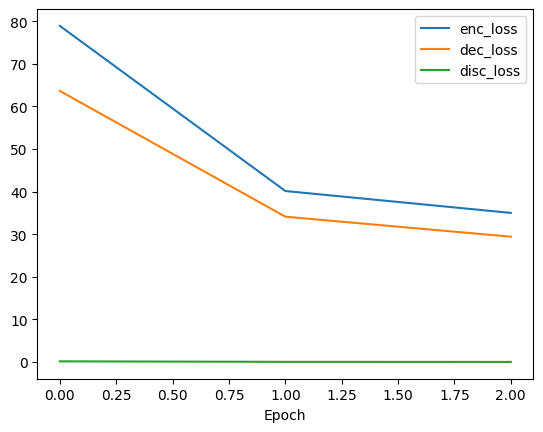

In [9]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['enc_loss', 'dec_loss', 'disc_loss', 'gen_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
        
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, model_name+".keras"))


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


In [10]:
## !!!!IMPORTANT!!!!
## Keep the seed the same across ALL HPO experiments. Be sure to reinitialize for EVERY new model.
tf.random.set_seed(1234)
## !!!!IMPORTANT!!!!

import itertools
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import datetime
import json

USE_CVAECGAN = True
USE_CVAE = False
USE_CGAN = False

# Instantiate a container with the hyperparameter(s) you want to test
hpo_grid = {
    "n_latent_dims":   [4, 16, 64],
    "learning_rate":   [1e-3, 1e-4, 3e-5],
    "enc_conv_units0": [32, 64],          
}


# Instantiate a model for a hyperparameter (combination)
## Note: I would recommend naming your model with the specific HPO you are trying at the moment.
keys, values = zip(*hpo_grid.items())
search_space = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total combos to train: {len(search_space)}")
results = []
nEpochs_hpo = 3                 
batch_size = 128
# Build a model with input / output dimensions

for run_idx, hp in enumerate(search_space, 1):
    print("\n", "="*70)
    print(f"[{run_idx}/{len(search_space)}]  HP setting:", hp)


    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    combo_name = (
        f"{model_name}"
        f"_ld{hp['n_latent_dims']}"
        f"_lr{hp['learning_rate']:.0e}"
        f"_enc{hp['enc_conv_units0']}"
    )
    combo_outdir = os.path.join(output_dir, combo_name)
    os.makedirs(combo_outdir, exist_ok=True)
    checkpoint_path = os.path.join(combo_outdir, "ckpt_final.keras")
    if os.path.exists(checkpoint_path):
        print(f"🚫 Skipping combo {combo_name} — already trained.")
        continue

    hpo_params_run = {
        "n_latent_dims": hp["n_latent_dims"],
        "learning_rate": hp["learning_rate"],
        "encoder_params": {
            
            "conv_layer_units": [hp["enc_conv_units0"], 64],
            "conv_layer_kernel_size": [4, 4],
            "conv_layer_strides": [(1, 1), (2, 2)],
            "conv_layer_activation_function": ["relu", "relu"],
            "encoder_dense_layer_units": [128],
            "decoder_dense_layer_units": [],
        },
        "decoder_params": { 
            "conv_layer_units": [hp["enc_conv_units0"], 64],
            "conv_layer_kernel_size": [4, 4],
            "conv_layer_strides": [(1, 1), (2, 2)],
            "conv_layer_activation_function": ["relu", "relu"],
            "encoder_dense_layer_units": [128],
            "decoder_dense_layer_units": [],
        },
        
        "generator_params": hpo_params["generator_params"],
        "discriminator_params": hpo_params["discriminator_params"],
    }
    # Compile the model
    if USE_CGAN:
            model = ConditionalGAN(
                n_classes      = n_classes,
                n_latent_dims  = hpo_params_run["n_latent_dims"],
                generator_params      = hpo_params_run["generator_params"],
                discriminator_params  = hpo_params_run["discriminator_params"],
            )
    elif USE_CVAE:
        model = ConditionalVAE(
            n_classes      = n_classes,
            n_latent_dims  = hpo_params_run["n_latent_dims"],
            encoder_params = hpo_params_run["encoder_params"],
            decoder_params = hpo_params_run["decoder_params"],
        )
    elif USE_CVAECGAN:
        model = ConditionalVAECGAN(
            adv_loss_weight = 10.,
            n_classes       = n_classes,
            n_latent_dims   = hpo_params_run["n_latent_dims"],
            encoder_params  = hpo_params_run["encoder_params"],
            decoder_params  = hpo_params_run["decoder_params"],
            discriminator_params = hpo_params_run["discriminator_params"],
        )
    else:
        raise ValueError("No model type selected!")


    # if USE_CVAE or USE_CVAECGAN:
    #     model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
    # if USE_CGAN or USE_CVAECGAN:
    #     model.discriminator.compute_output_shape((None, 32, 32, 1))


    opt = tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"])
    callbacks = [
        CSVLogger(os.path.join(combo_outdir, "training_log.csv")),
        EarlyStopping(
            monitor="loss", patience=5, restore_best_weights=True, verbose=1
        ),
    ]
# Fit model to the data
    if USE_CGAN:
            callbacks.append(
                GenerateImagesConditional(
                    output_dir=combo_outdir,
                    model=model,
                    example_labels=labels_onehot[:10],
                    n_generated_images=10,
                    n_latent_dims=model.n_latent_dims,
                )
            )
    else:
        callbacks.append(
            SaveImagesConditional(
                output_dir=combo_outdir,
                model=model,
                example_images=data.images_train[:10],
                example_labels=labels_onehot[:10],
                n_generated_images=10,
                n_latent_dims=model.n_latent_dims,
            )
        )
    if USE_CVAE or USE_CGAN:
        model.compile(optimizer=opt)
    else:
        model.compile(optimizer_encoder = tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]),
                      optimizer_decoder=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]),
                      optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"]))

    history = model.fit(
        [data.images_train, labels_onehot],
        batch_size=batch_size,
        epochs=nEpochs_hpo,
        callbacks=callbacks,
        verbose=1,
    )
    '''
        self.loss_recon_tracker = tf.keras.metrics.Mean(name='recon_loss')
        self.loss_kl_tracker = tf.keras.metrics.Mean(name='kl_loss')
        self.loss_enc_tracker = tf.keras.metrics.Mean(name='enc_loss')
        self.loss_dec_tracker = tf.keras.metrics.Mean(name='dec_loss')
        self.loss_disc_tracker = tf.keras.metrics.Mean(name='disc_loss')
    '''

    recon_loss = history.history["recon_loss"][-1]
    kl_loss = history.history["kl_loss"][-1]
    enc_loss = history.history["enc_loss"][-1]
    dec_loss = history.history["dec_loss"][-1]
    disc_loss = history.history["disc_loss"][-1]
    results.append(
        {
            "run_name": combo_name,
            **hp,
            "recon_loss": float(recon_loss),
            "kl_loss": float(kl_loss),
            "enc_loss": float(enc_loss),
            "dec_loss": float(dec_loss),
            "disc_loss": float(disc_loss),
        }
    )

    model.save(os.path.join(combo_outdir, "ckpt_final.keras"))

# Plot the training curves for the model

# Save the model 
sort_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]
top_k = 5

print("\n===== HPO Finished. Top-K Runs by Each Loss Metric =====\n")

for key in sort_keys:
    sorted_res = sorted(results, key=lambda x: x.get(key, float('inf')))
    print(f"📉 Top-{top_k} runs sorted by {key}:")
    for rank, res in enumerate(sorted_res[:top_k], 1):
        hps = {k: res[k] for k in hpo_grid.keys()}
        loss_val = res.get(key, None)
        print(f" {rank:>2d}. {res['run_name']:35s} {key} = {loss_val:.4f} → {hps}")
    print("-" * 80)

# ---- Write all results into a JSON file ----
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_path = os.path.join(output_dir, f"hpo_all_losses_{ts}.json")
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ All HPO results saved to: {json_path}")


Total combos to train: 18

[1/18]  HP setting: {'n_latent_dims': 4, 'learning_rate': 0.001, 'enc_conv_units0': 32}
🚫 Skipping combo cvaecgan_ld4_lr1e-03_enc32 — already trained.

[2/18]  HP setting: {'n_latent_dims': 4, 'learning_rate': 0.001, 'enc_conv_units0': 64}
🚫 Skipping combo cvaecgan_ld4_lr1e-03_enc64 — already trained.

[3/18]  HP setting: {'n_latent_dims': 4, 'learning_rate': 0.0001, 'enc_conv_units0': 32}
🚫 Skipping combo cvaecgan_ld4_lr1e-04_enc32 — already trained.

[4/18]  HP setting: {'n_latent_dims': 4, 'learning_rate': 0.0001, 'enc_conv_units0': 64}
🚫 Skipping combo cvaecgan_ld4_lr1e-04_enc64 — already trained.

[5/18]  HP setting: {'n_latent_dims': 4, 'learning_rate': 3e-05, 'enc_conv_units0': 32}
🚫 Skipping combo cvaecgan_ld4_lr3e-05_enc32 — already trained.

[6/18]  HP setting: {'n_latent_dims': 4, 'learning_rate': 3e-05, 'enc_conv_units0': 64}
🚫 Skipping combo cvaecgan_ld4_lr3e-05_enc64 — already trained.

[7/18]  HP setting: {'n_latent_dims': 16, 'learning_rate': 

I0000 00:00:1748579058.086598   55533 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748579059.559751   55529 service.cc:152] XLA service 0x2aae9a164760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748579059.559791   55529 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748579059.763543   55529 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 36s 54ms/step - recon_loss: 91.3830 - kl_loss: 8.7192 - class_loss: 0.5313 - enc_loss: 100.1022 - dec_loss: 92.1287 - disc_loss: 0.5701 - top_1_acc: 0.8446
Epoch 2/3
469/469 [==============================] - 24s 52ms/step - recon_loss: 48.3040 - kl_loss: 9.4568 - class_loss: 0.1605 - enc_loss: 57.7608 - dec_loss: 48.6715 - disc_loss: 0.1641 - top_1_acc: 0.9554
Epoch 3/3
469/469 [==============================] - 24s 52ms/step - recon_loss: 42.1375 - kl_loss: 9.8460 - class_loss: 0.1072 - enc_loss: 51.9835 - dec_loss: 42.3664 - disc_loss: 0.1089 - top_1_acc: 0.9706


/project/nanocourse/SWE_OOP/shared/CondaEnvs/lib/python3.12/site-packages/tf_keras/src/saving/saving_api.py:227: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, local_filepath)



[12/18]  HP setting: {'n_latent_dims': 16, 'learning_rate': 3e-05, 'enc_conv_units0': 64}
Epoch 1/3
469/469 [==============================] - 39s 66ms/step - recon_loss: 55.2332 - kl_loss: 7.0004 - class_loss: 0.5587 - enc_loss: 62.2337 - dec_loss: 55.6593 - disc_loss: 0.6136 - top_1_acc: 0.8347
Epoch 2/3
469/469 [==============================] - 30s 64ms/step - recon_loss: 28.2675 - kl_loss: 9.6524 - class_loss: 0.1788 - enc_loss: 37.9199 - dec_loss: 28.4490 - disc_loss: 0.1860 - top_1_acc: 0.9515
Epoch 3/3
469/469 [==============================] - 31s 66ms/step - recon_loss: 24.2396 - kl_loss: 10.1844 - class_loss: 0.1144 - enc_loss: 34.4241 - dec_loss: 24.3679 - disc_loss: 0.1183 - top_1_acc: 0.9686

[13/18]  HP setting: {'n_latent_dims': 64, 'learning_rate': 0.001, 'enc_conv_units0': 32}
Epoch 1/3
469/469 [==============================] - 32s 51ms/step - recon_loss: 43.1769 - kl_loss: 33.3224 - class_loss: 0.1929 - enc_loss: 76.4994 - dec_loss: 43.4602 - disc_loss: 0.1973 - to

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hpo_training_curves(results_sorted, output_dir, max_curves=5):
    """
    Plot loss curves from top-k HPO runs for each loss type.
    
    Args:
        results_sorted (list of dict): HPO result dicts.
        output_dir (str): Base directory with all combo subfolders.
        max_curves (int): How many runs to plot per loss type.
    """
    log_filename = "training_log.csv"
    loss_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]

    for loss_key in loss_keys:
        print(f"\n📈 Plotting '{loss_key}' curves for top {max_curves} runs...")
        plt.figure(figsize=(10, 6))

        # 排序并选出 top runs
        sorted_runs = sorted(results_sorted, key=lambda x: x.get(loss_key, float('inf')))
        plotted = 0

        for res in sorted_runs:
            if plotted >= max_curves:
                break

            run_name = res["run_name"]
            log_path = os.path.join(output_dir, run_name, log_filename)

            if not os.path.exists(log_path):
                print(f"⚠️  Missing log: {log_path}")
                continue

            df = pd.read_csv(log_path)
            if loss_key not in df.columns:
                print(f"⚠️  '{loss_key}' not in log: {log_path}")
                continue

            plt.plot(df[loss_key], label=run_name)
            plotted += 1

        if plotted == 0:
            print(f"⚠️  No valid logs found for {loss_key}")
            continue

        plt.title(f"Top {max_curves} Curves - {loss_key}")
        plt.xlabel("Epoch")
        plt.ylabel(loss_key)
        plt.legend(fontsize="small", loc="upper right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


📈 Plotting 'recon_loss' curves for top 5 runs...


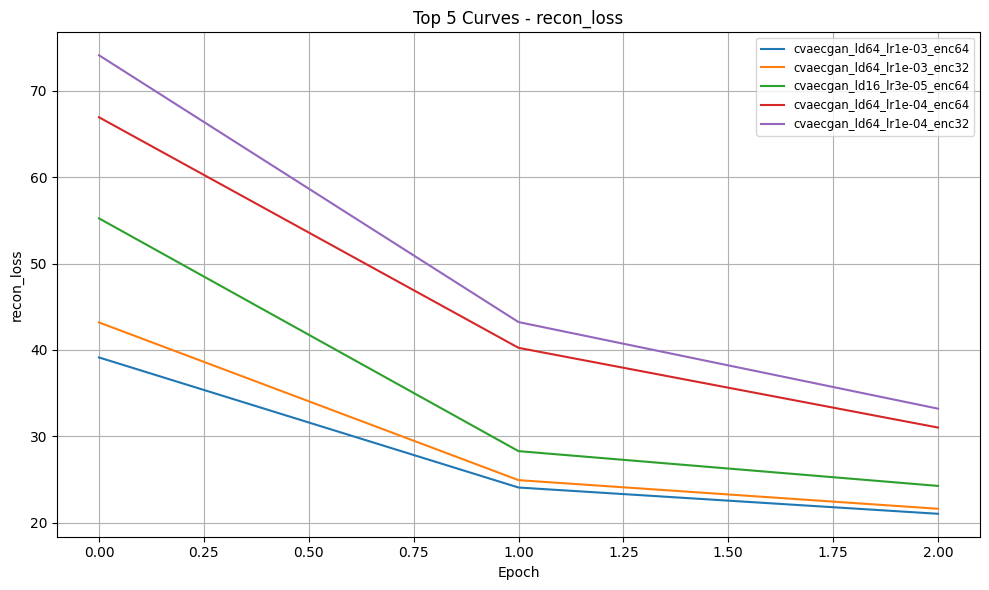


📈 Plotting 'kl_loss' curves for top 5 runs...


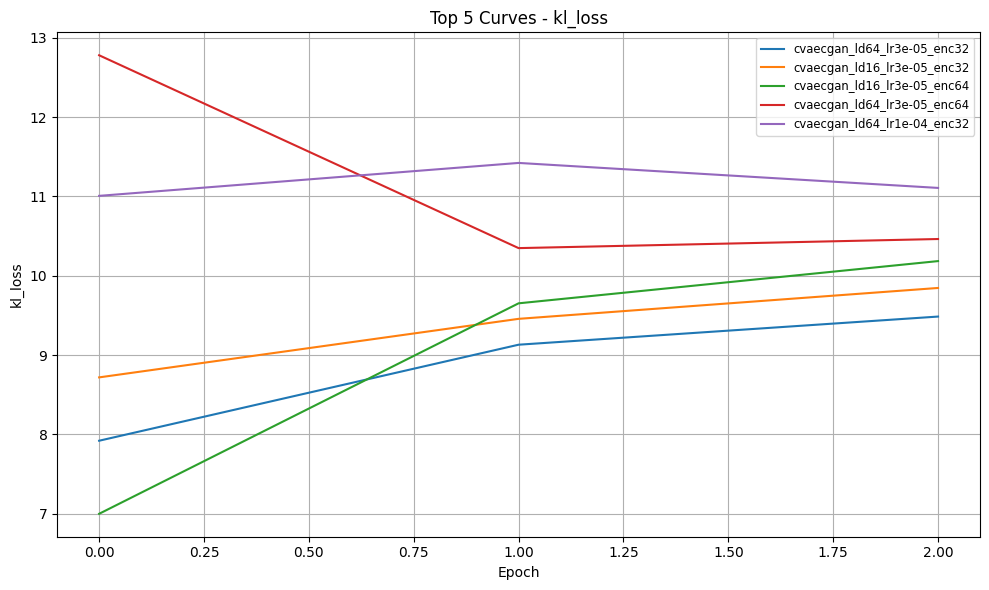


📈 Plotting 'enc_loss' curves for top 5 runs...


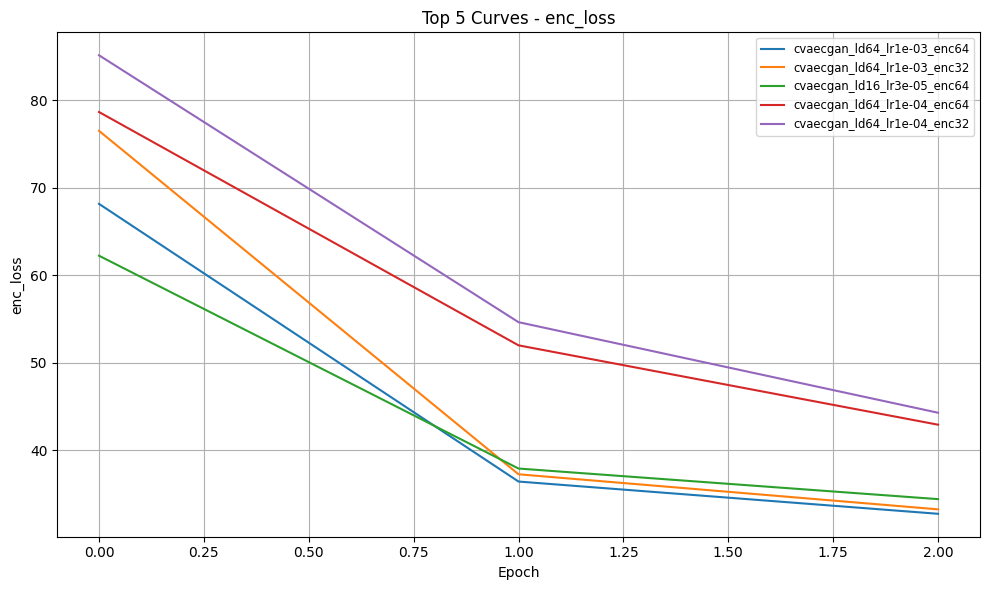


📈 Plotting 'dec_loss' curves for top 5 runs...


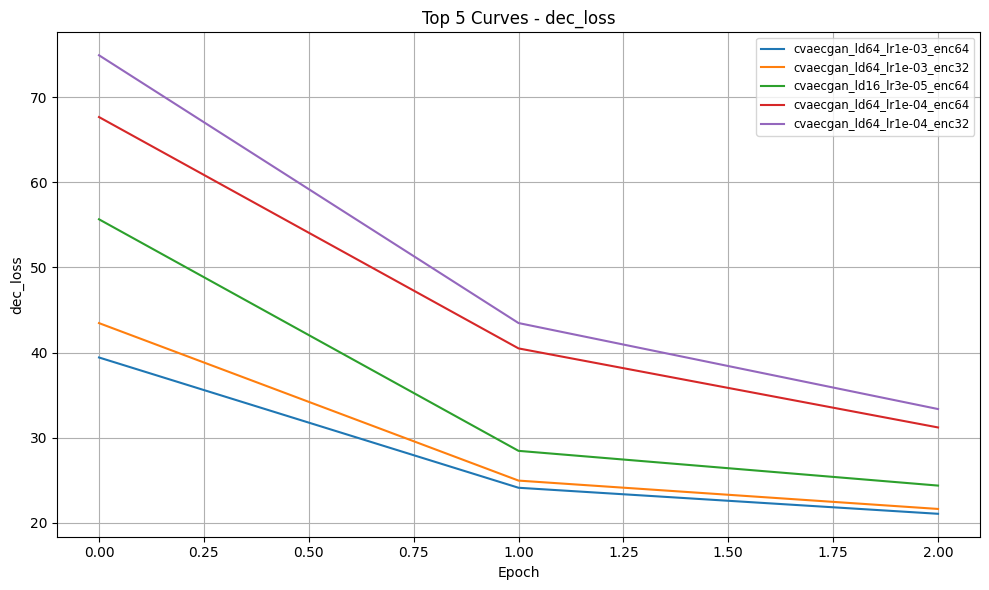


📈 Plotting 'disc_loss' curves for top 5 runs...


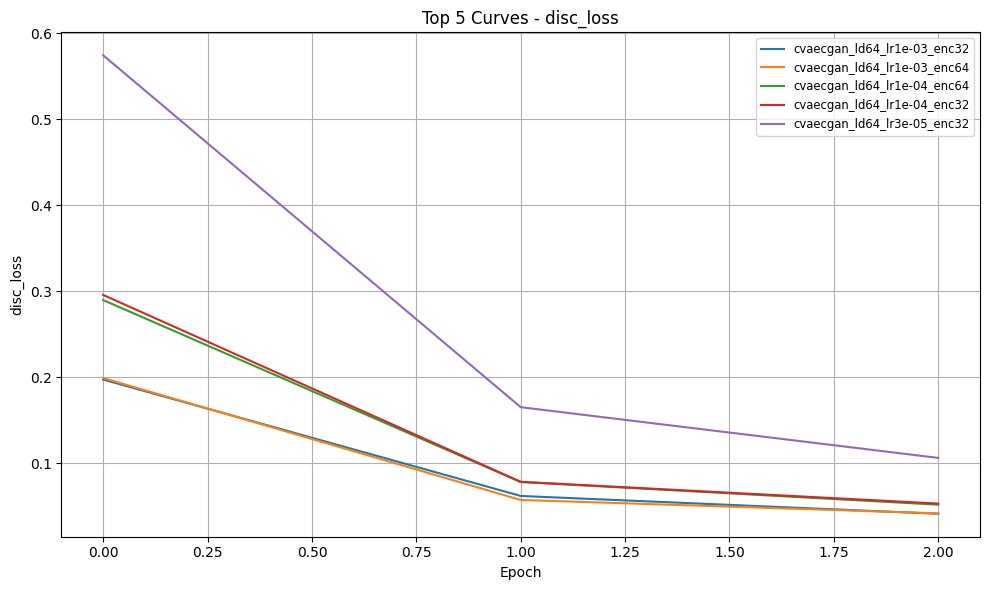


📈 Plotting 'recon_loss' curves for top 5 runs...


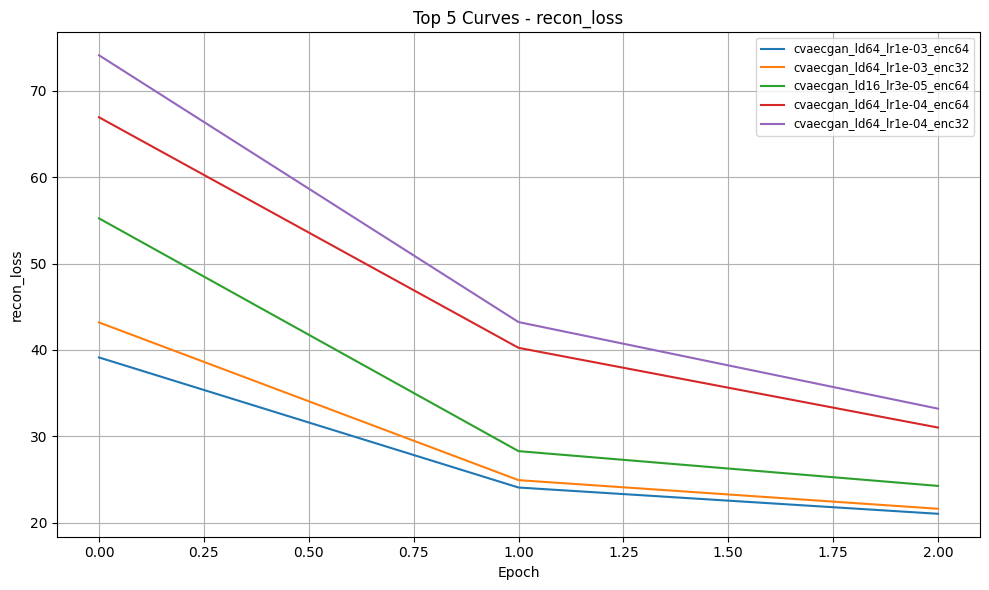


📈 Plotting 'kl_loss' curves for top 5 runs...


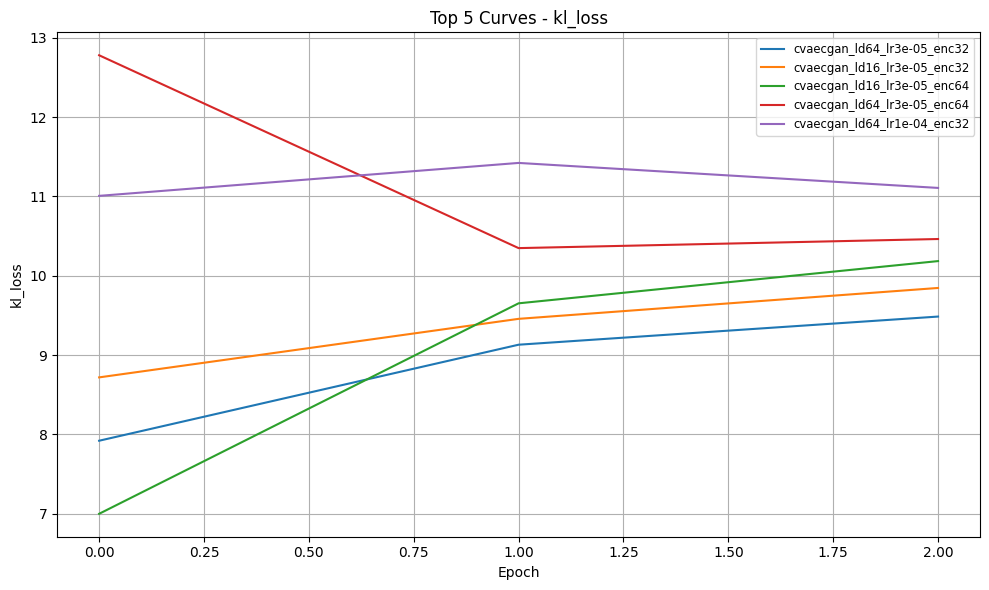


📈 Plotting 'enc_loss' curves for top 5 runs...


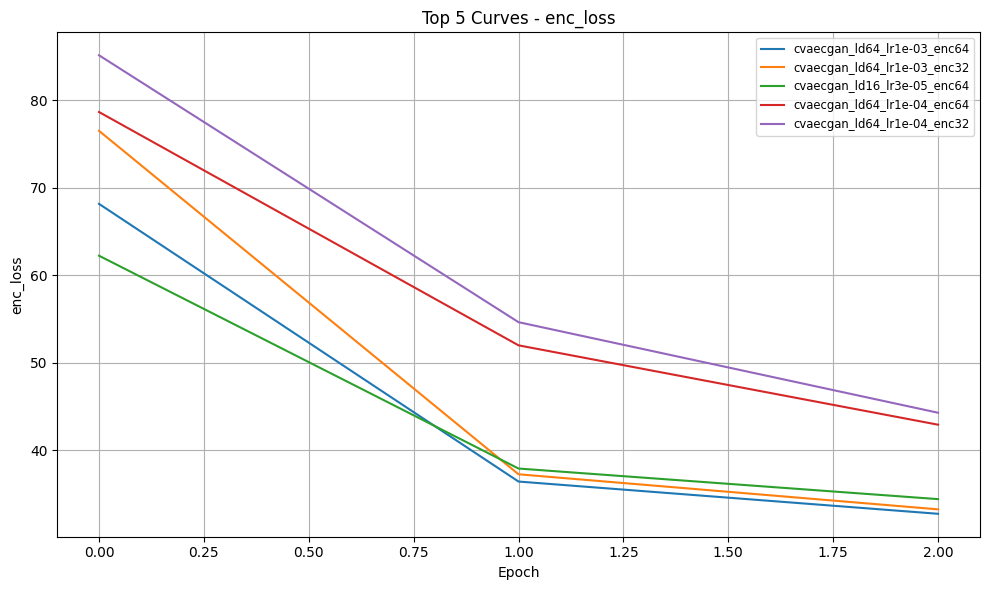


📈 Plotting 'dec_loss' curves for top 5 runs...


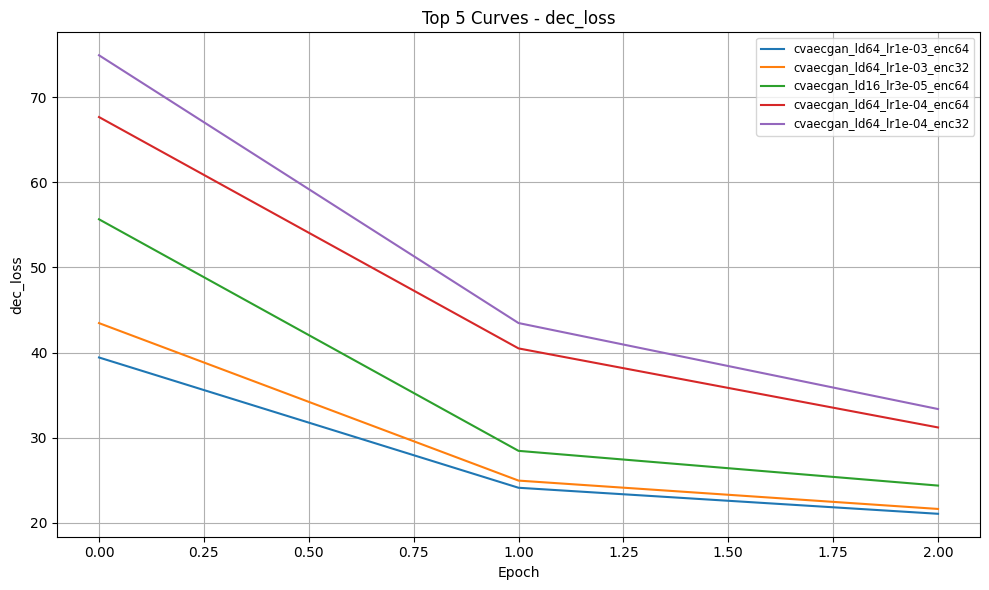


📈 Plotting 'disc_loss' curves for top 5 runs...


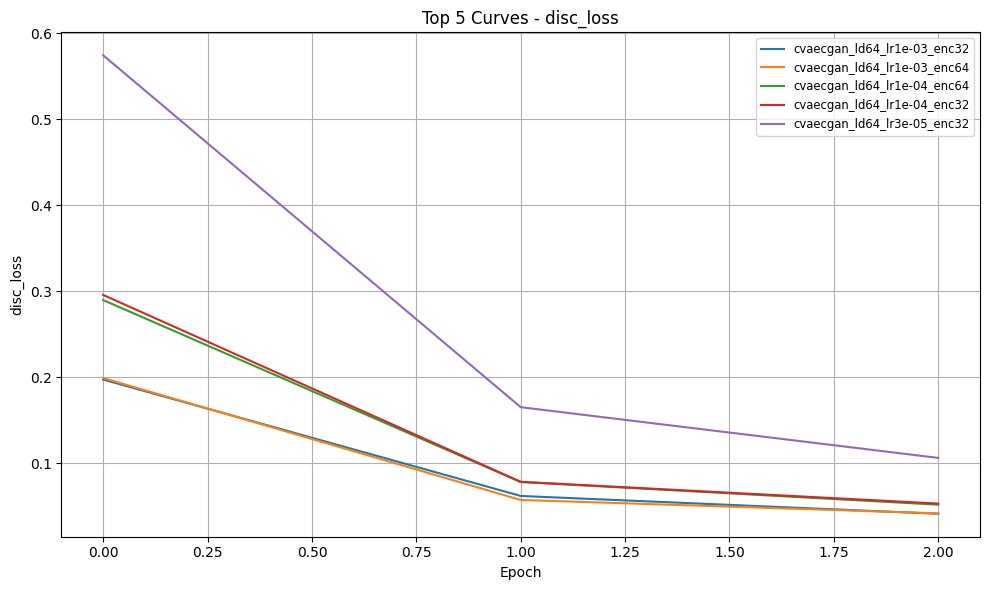


📈 Plotting 'recon_loss' curves for top 5 runs...


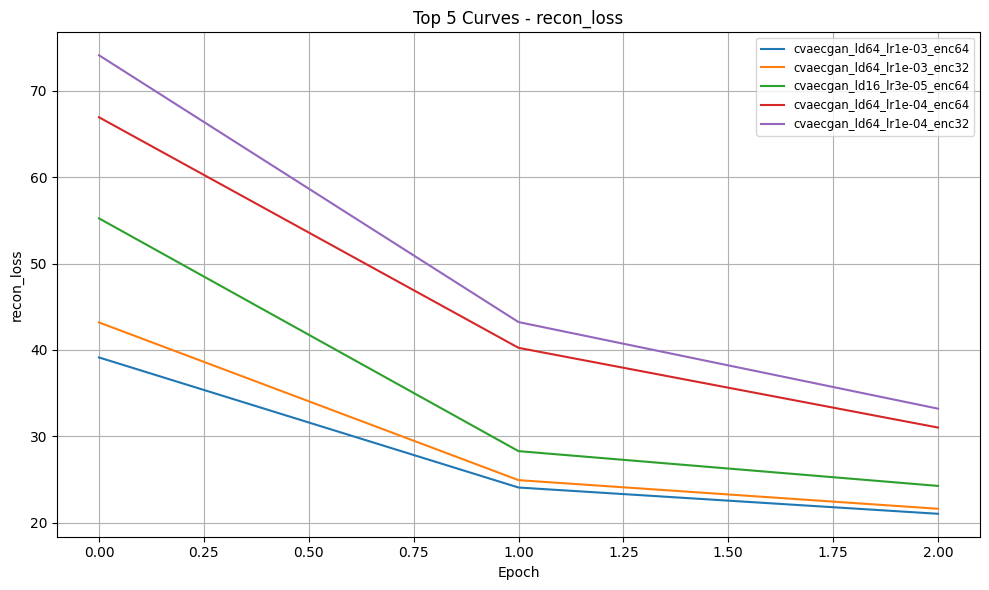


📈 Plotting 'kl_loss' curves for top 5 runs...


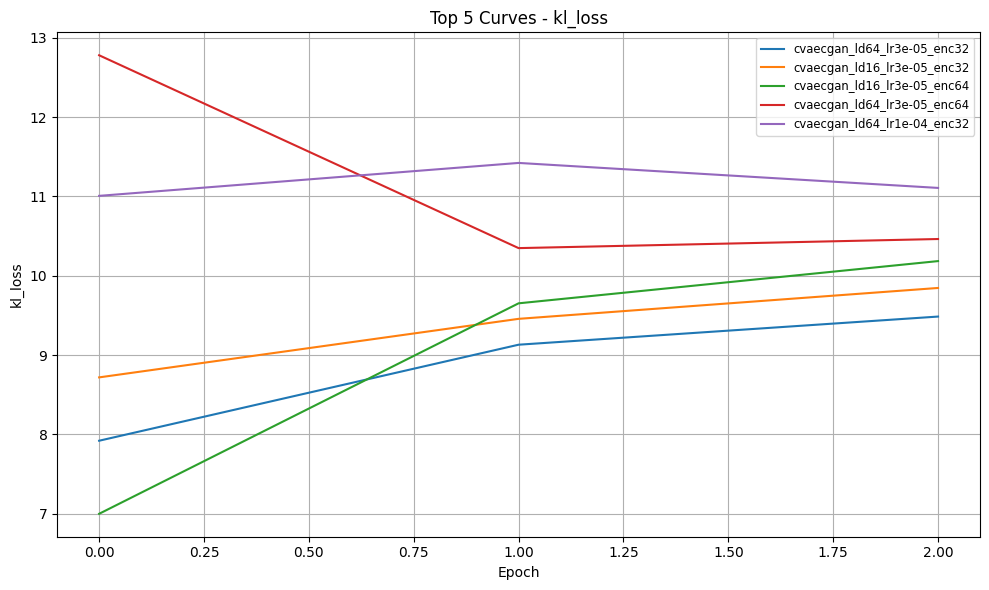


📈 Plotting 'enc_loss' curves for top 5 runs...


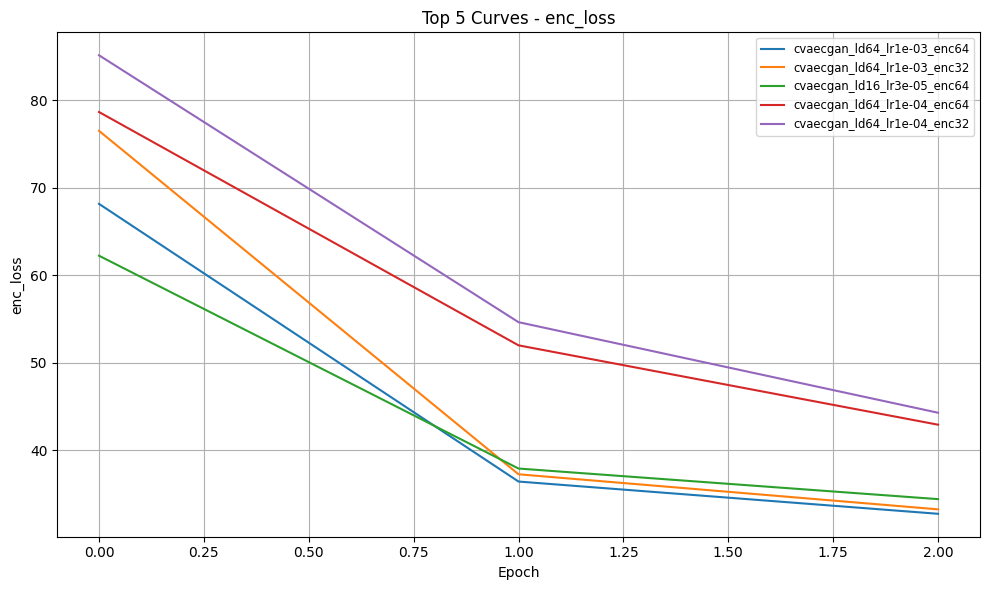


📈 Plotting 'dec_loss' curves for top 5 runs...


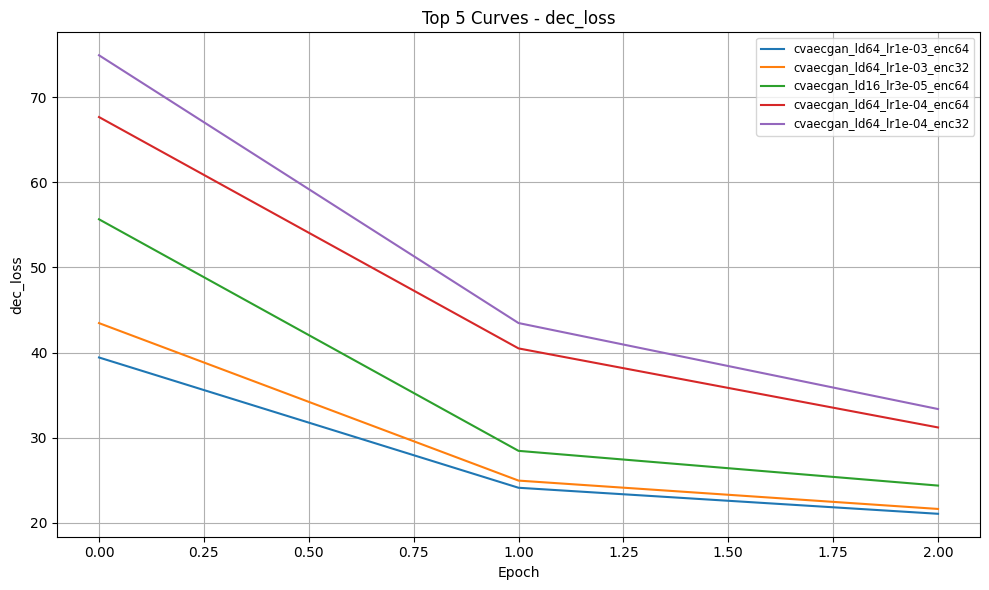


📈 Plotting 'disc_loss' curves for top 5 runs...


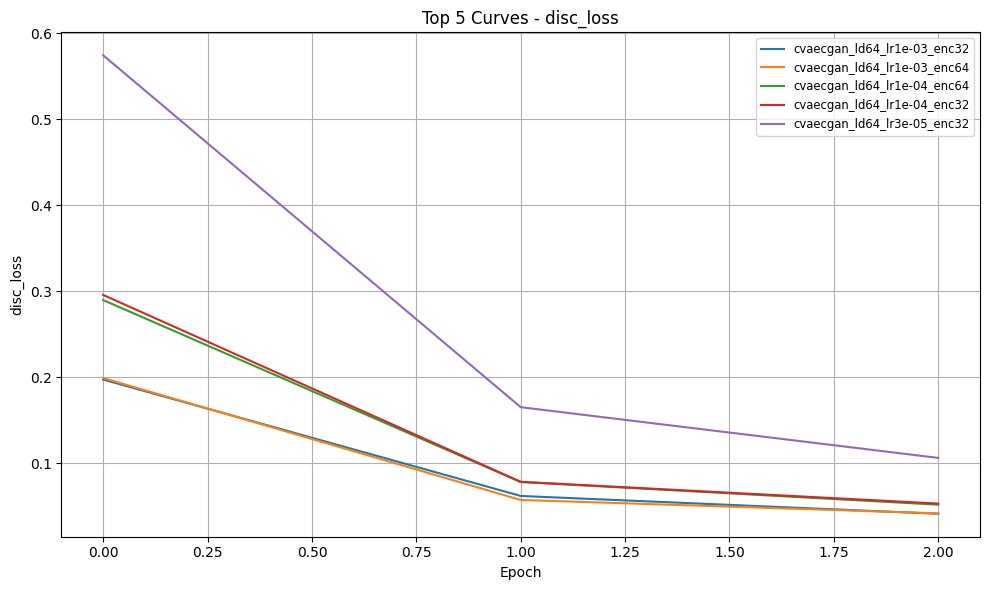


📈 Plotting 'recon_loss' curves for top 5 runs...


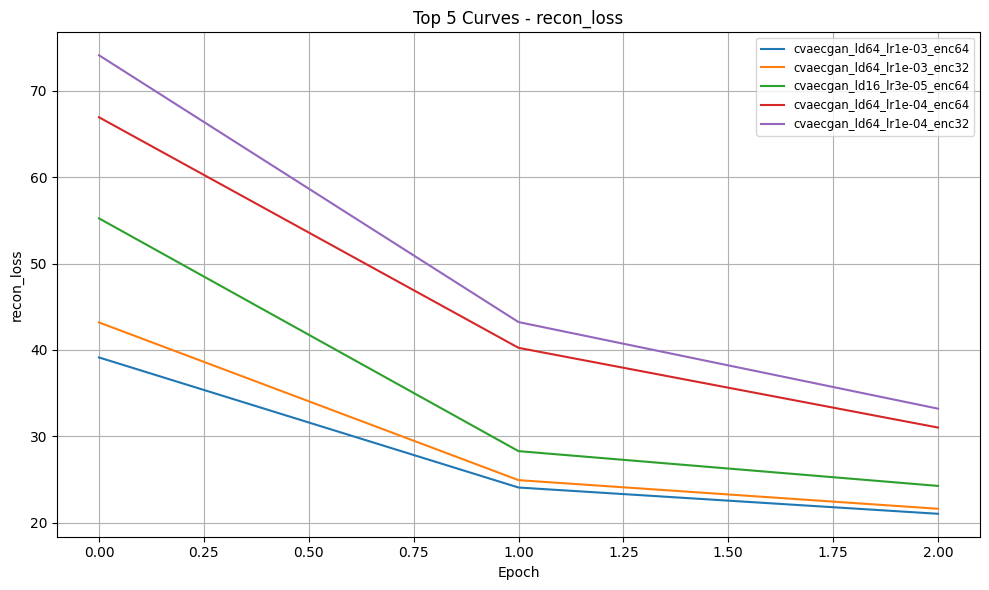


📈 Plotting 'kl_loss' curves for top 5 runs...


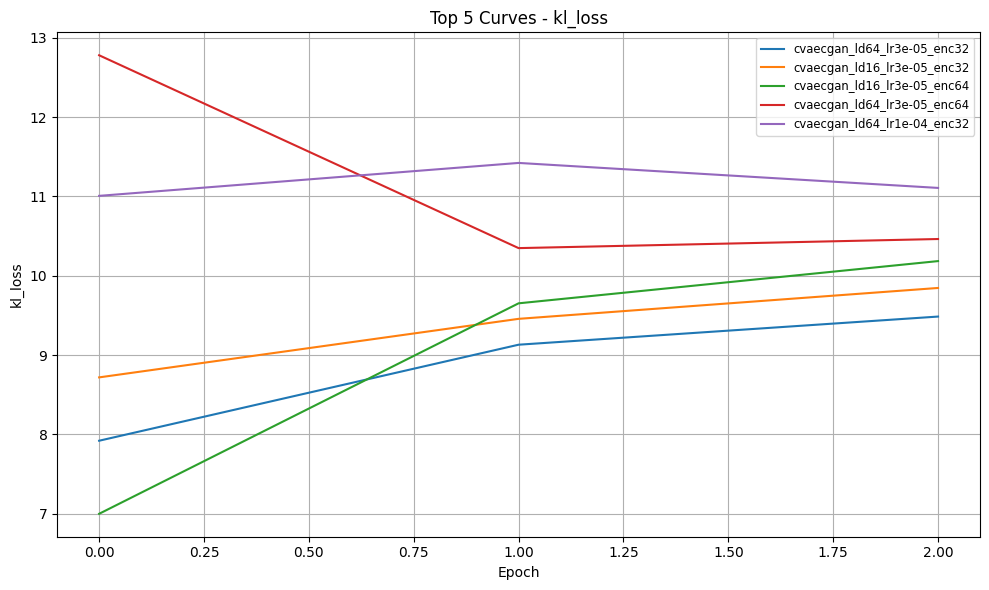


📈 Plotting 'enc_loss' curves for top 5 runs...


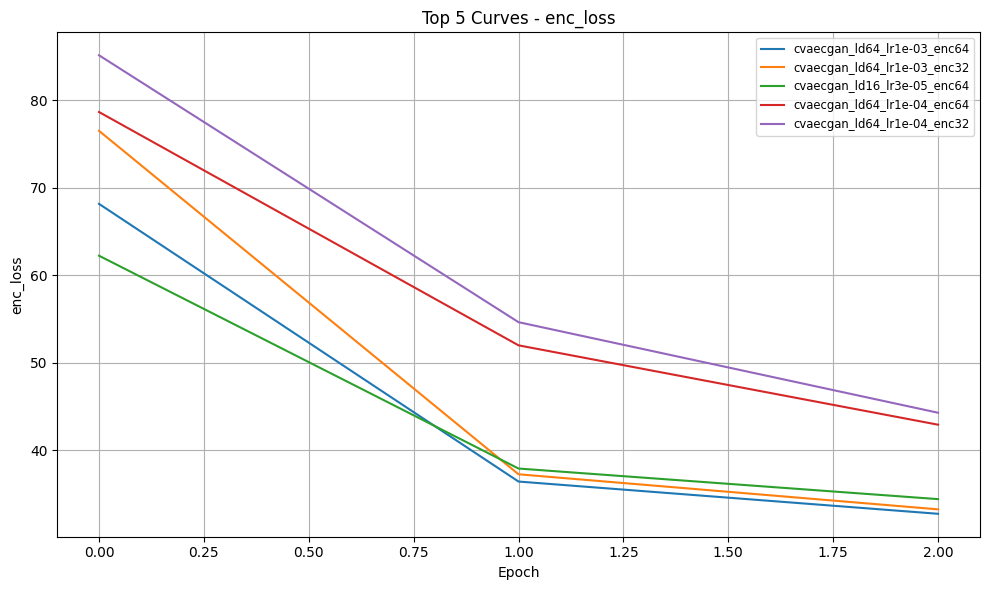


📈 Plotting 'dec_loss' curves for top 5 runs...


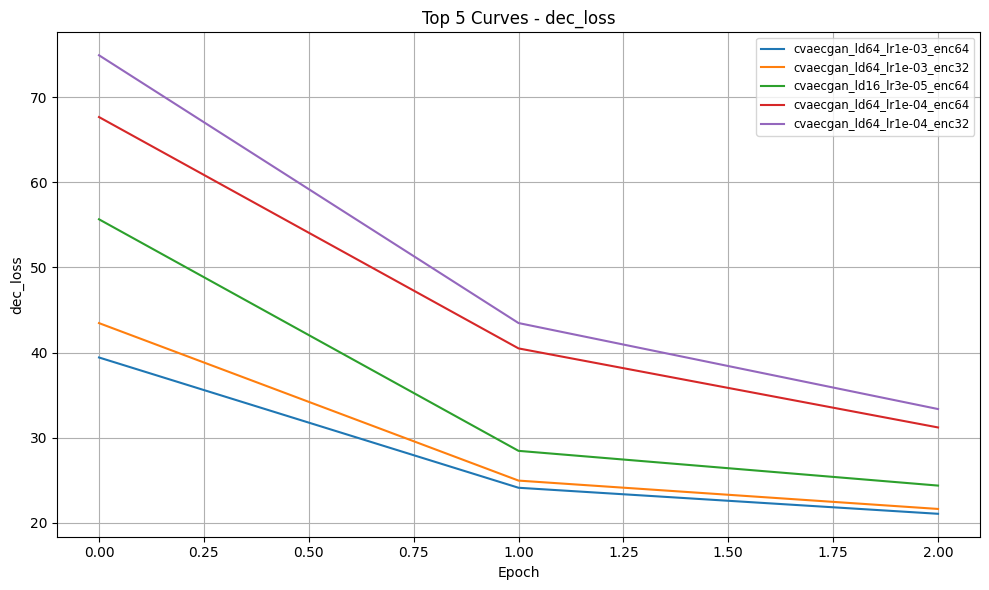


📈 Plotting 'disc_loss' curves for top 5 runs...


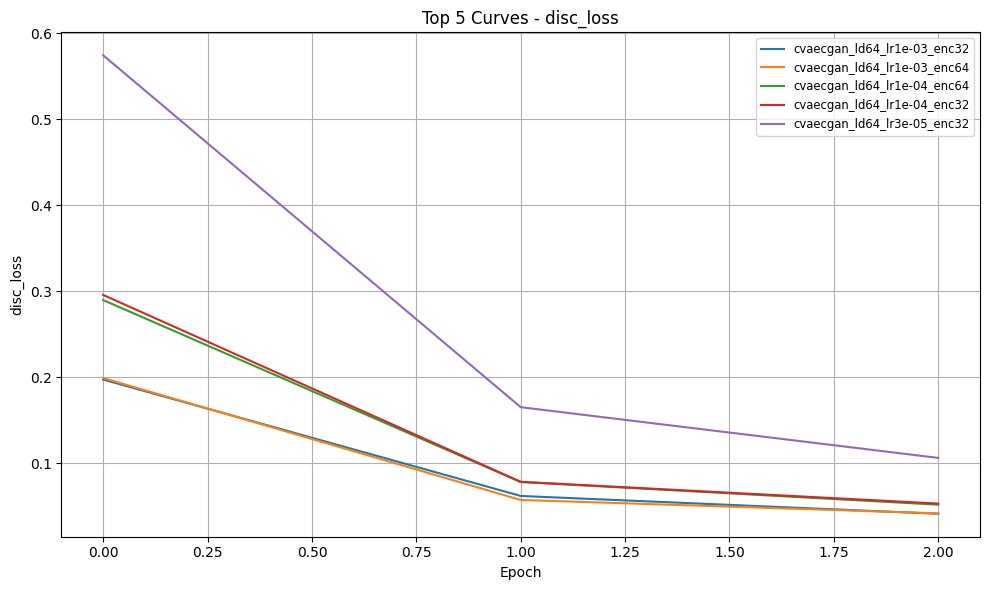


📈 Plotting 'recon_loss' curves for top 5 runs...


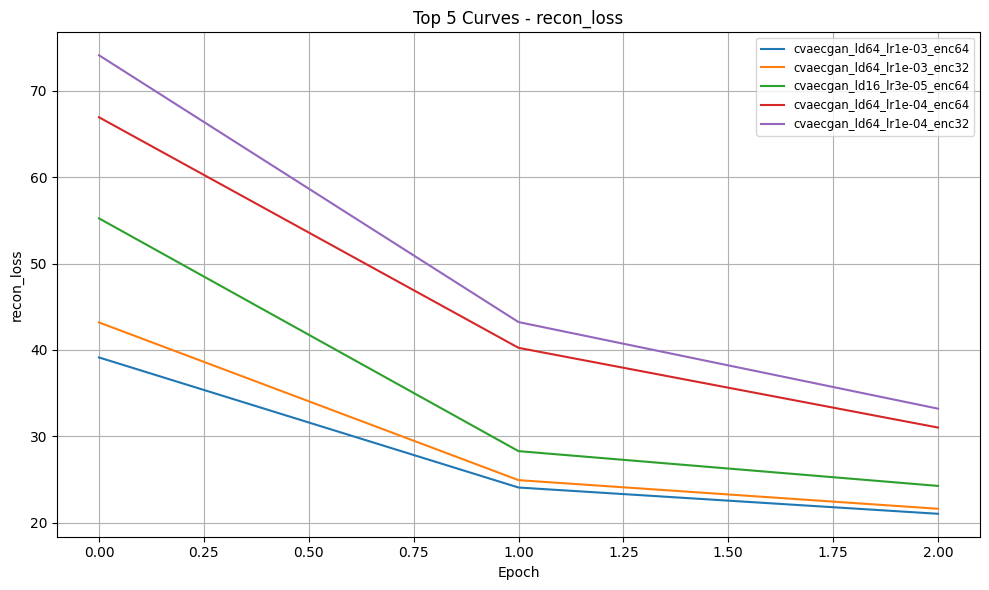


📈 Plotting 'kl_loss' curves for top 5 runs...


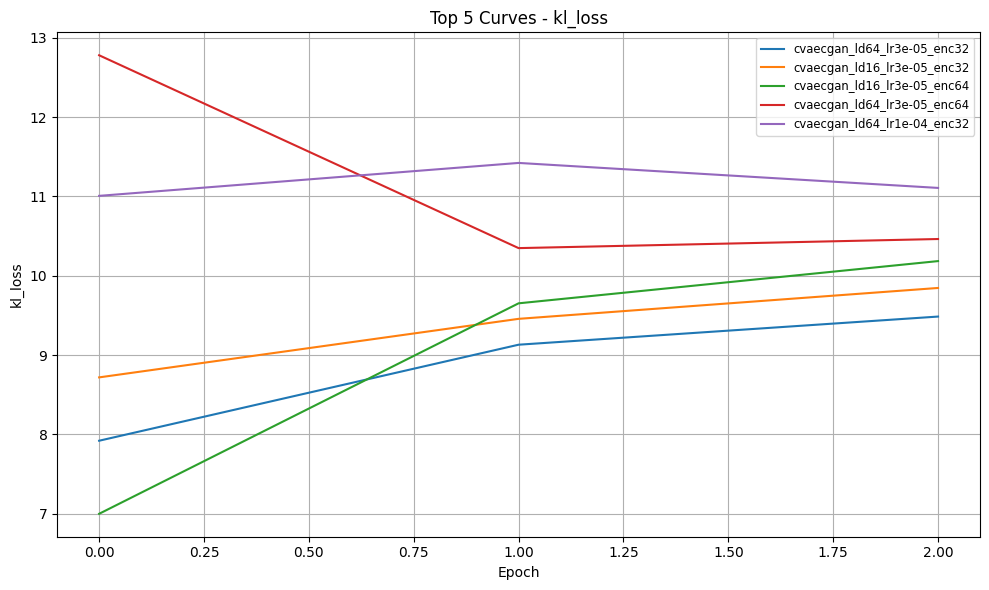


📈 Plotting 'enc_loss' curves for top 5 runs...


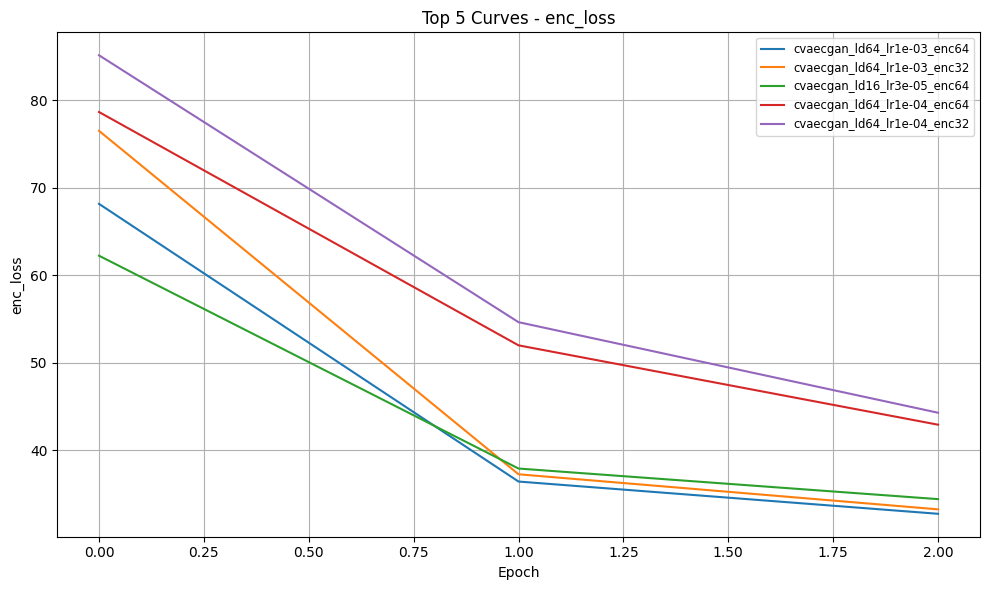


📈 Plotting 'dec_loss' curves for top 5 runs...


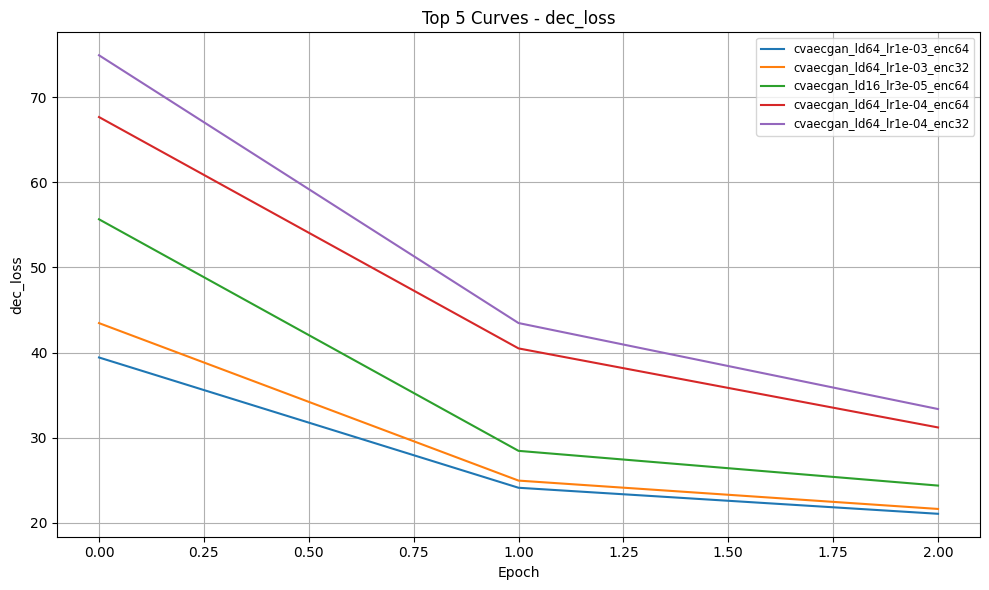


📈 Plotting 'disc_loss' curves for top 5 runs...


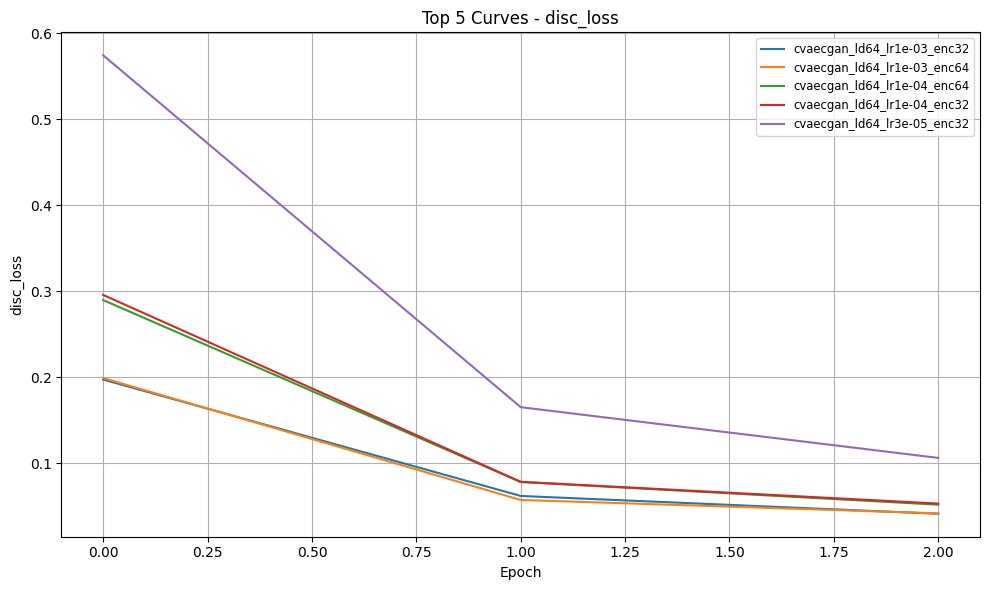

In [16]:
sort_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]
top_k = 5
for key in sort_keys:
    results_sorted = sorted(results, key=lambda x: x[key])
    plot_hpo_training_curves(results_sorted, output_dir, max_curves=5)


In [30]:

import os
import pandas as pd
import re

def parse_hparams_from_name(name):
    """从 combo_name 中提取超参数字典"""
    pattern = r"ld(?P<n_latent_dims>\d+)_lr(?P<learning_rate>[\de\.-]+)_enc(?P<enc_conv_units0>\d+)"
    match = re.search(pattern, name)
    if match:
        d = match.groupdict()
        d["n_latent_dims"] = int(d["n_latent_dims"])
        d["enc_conv_units0"] = int(d["enc_conv_units0"])
        d["learning_rate"] = float(d["learning_rate"])
        return d
    else:
        return None

def collect_hpo_results_from_logs(output_dir, loss_keys=None):
    """
    自动从 output_dir 中每个组合的 training_log.csv 提取最终 loss 并汇总为 results[] 列表
    """
    if loss_keys is None:
        loss_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]

    results = []
    for subdir in os.listdir(output_dir):
        log_path = os.path.join(output_dir, subdir, "training_log.csv")
        if not os.path.exists(log_path):
            print(str(log_path)+"not exist")
            continue

        try:
            df = pd.read_csv(log_path)
            if not all(k in df.columns for k in loss_keys):
                print(f"⚠️ Some loss keys missing in {log_path}")
                continue

            hps = parse_hparams_from_name(subdir)
            if hps is None:
                continue

            last_row = df.iloc[-1]  # 最后一行（最终 epoch）
            res = {
                "run_name": subdir,
                **hps,
                **{k: float(last_row[k]) for k in loss_keys},
            }
            results.append(res)

        except Exception as e:
            print(f"❌ Failed to parse {log_path}: {e}")

    return results



outputs/mnist_hpo_cvaecgan/hpo_all_losses_20250529_233633.json/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/example_images.png/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/epoch002_fakes.png/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/training_curves.png/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/epoch002_recons.png/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/epoch003_fakes.png/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/cvaecgan.keras/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/epoch001_fakes.png/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/epoch003_recons.png/training_log.csvnot exist
outputs/mnist_hpo_cvaecgan/epoch001_recons.png/training_log.csvnot exist
[{'run_name': 'cvaecgan_ld64_lr3e-05_enc64', 'n_latent_dims': 64, 'learning_rate': 3e-05, 'enc_conv_units0': 64, 'recon_loss': 46.4898567199707, 'kl_loss': 10.46263313293457, 'enc_loss': 56.95249557495117, 'dec_loss': 46.809852600097656, 'disc_loss': 0.1087098345

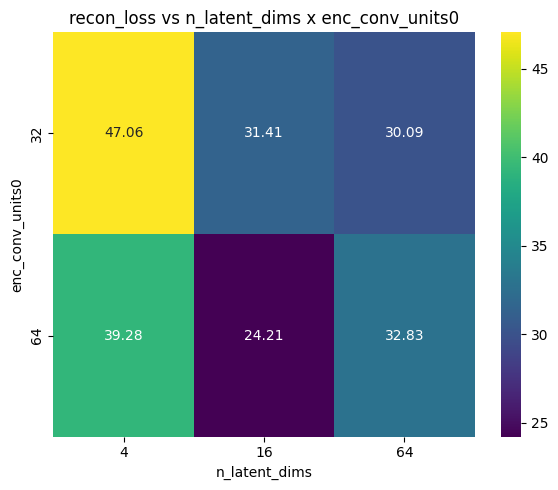

In [34]:
output_dir = "outputs/mnist_hpo_cvaecgan"  
results = collect_hpo_results_from_logs(output_dir)
print(results)

plot_loss_heatmap(results, xkey="n_latent_dims", ykey="enc_conv_units0", zkey="recon_loss")



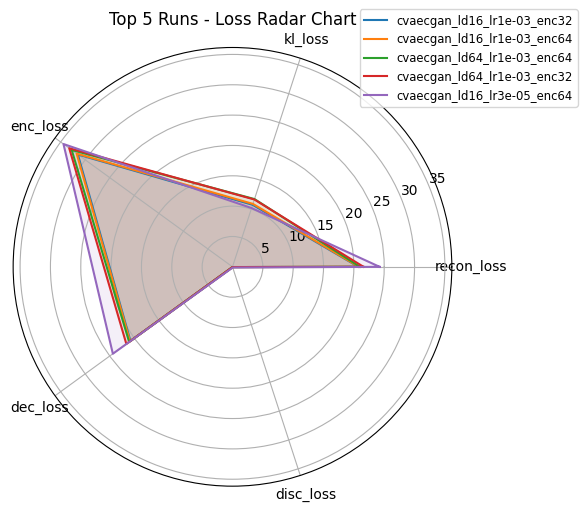

In [35]:
import os
import pandas as pd
import re
from math import pi
import matplotlib.pyplot as plt

# Parse hparams from folder name
def parse_hparams_from_name(name):
    pattern = r"ld(?P<n_latent_dims>\d+)_lr(?P<learning_rate>[\de\.-]+)_enc(?P<enc_conv_units0>\d+)"
    match = re.search(pattern, name)
    if match:
        d = match.groupdict()
        d["n_latent_dims"] = int(d["n_latent_dims"])
        d["enc_conv_units0"] = int(d["enc_conv_units0"])
        d["learning_rate"] = float(d["learning_rate"])
        return d
    return None

# Collect results
def collect_hpo_results_from_logs(output_dir, loss_keys=None):
    if loss_keys is None:
        loss_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]
    results = []
    for subdir in os.listdir(output_dir):
        log_path = os.path.join(output_dir, subdir, "training_log.csv")
        if not os.path.exists(log_path):
            continue
        try:
            df = pd.read_csv(log_path)
            if not all(k in df.columns for k in loss_keys):
                continue
            hps = parse_hparams_from_name(subdir)
            if hps is None:
                continue
            last_row = df.iloc[-1]
            res = {
                "run_name": subdir,
                **hps,
                **{k: float(last_row[k]) for k in loss_keys},
            }
            results.append(res)
        except Exception:
            continue
    return pd.DataFrame(results)

# Radar chart
def plot_radar_chart_from_dir(output_dir, top_k=5, loss_keys=None):
    df = collect_hpo_results_from_logs(output_dir, loss_keys)
    if df.empty:
        print("No valid logs found.")
        return
    if loss_keys is None:
        loss_keys = ["recon_loss", "kl_loss", "enc_loss", "dec_loss", "disc_loss"]
    df_top = df.nsmallest(top_k, "recon_loss")

    N = len(loss_keys)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    for _, row in df_top.iterrows():
        values = [row[k] for k in loss_keys]
        values += values[:1]
        ax.plot(angles, values, label=row["run_name"])
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(loss_keys)
    plt.title(f"Top {top_k} Runs - Loss Radar Chart")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize="small")
    plt.tight_layout()
    plt.show()

# Example call
plot_radar_chart_from_dir("outputs/mnist_hpo_cvaecgan")


In [38]:
model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'])

Loaded version: vaegan.vae_SOLUTIONS
Loaded version: vaegan.vae_SOLUTIONS
